## Import Libraries

In [1]:
from warnings import filterwarnings
filterwarnings(action="ignore")

from tabulate import tabulate

import numpy as np
import pandas as pd

from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

from sklearn import metrics

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

## load data

In [2]:
train = pd.read_csv("bigmart_train.csv")
test = pd.read_csv("bigmart_test.csv")

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (8523, 12)
Test: (5681, 11)


In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
total_df = pd.concat([train, test])

In [5]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.4+ MB


In [6]:
cat_feat = total_df.select_dtypes(include="O")

num_feat = total_df.select_dtypes(exclude="O")

In [7]:
num_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,11765.0,12.792854,4.652502,4.555,8.710000,12.600000,16.750000,21.350000
Item_Visibility,14204.0,0.065953,0.051459,0.000,0.027036,0.054021,0.094037,0.328391
Item_MRP,14204.0,141.004977,62.086938,31.290,94.012000,142.247000,185.855600,266.888400
Outlet_Establishment_Year,14204.0,1997.830681,8.371664,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [8]:
cat_feat.describe().T

,count,unique,top,freq
Item_Identifier,14204,1559,FDU15,10
Item_Fat_Content,14204,5,Low Fat,8485
Item_Type,14204,16,Fruits and Vegetables,2013
Outlet_Identifier,14204,10,OUT027,1559
Outlet_Size,10188,3,Medium,4655
Outlet_Location_Type,14204,3,Tier 3,5583
Outlet_Type,14204,4,Supermarket Type1,9294


In [9]:
cat_feat.isnull().sum()

Item_Identifier            0
Item_Fat_Content           0
Item_Type                  0
Outlet_Identifier          0
Outlet_Size             4016
Outlet_Location_Type       0
Outlet_Type                0
dtype: int64

In [10]:
num_feat.isnull().sum()

Item_Weight                  2439
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
Item_Outlet_Sales            5681
dtype: int64

## Exploratory Data Analysis

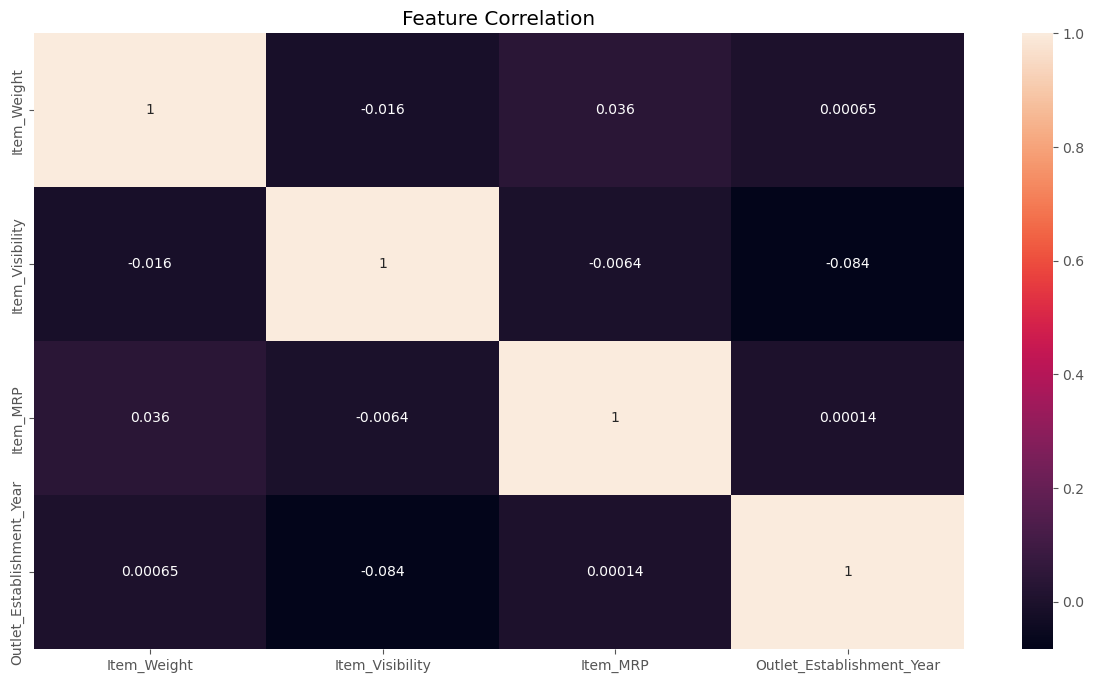

In [11]:
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(num_feat.corr().iloc[:-1, :-1], annot=True)
heatmap.set_title("Feature Correlation")
plt.show()

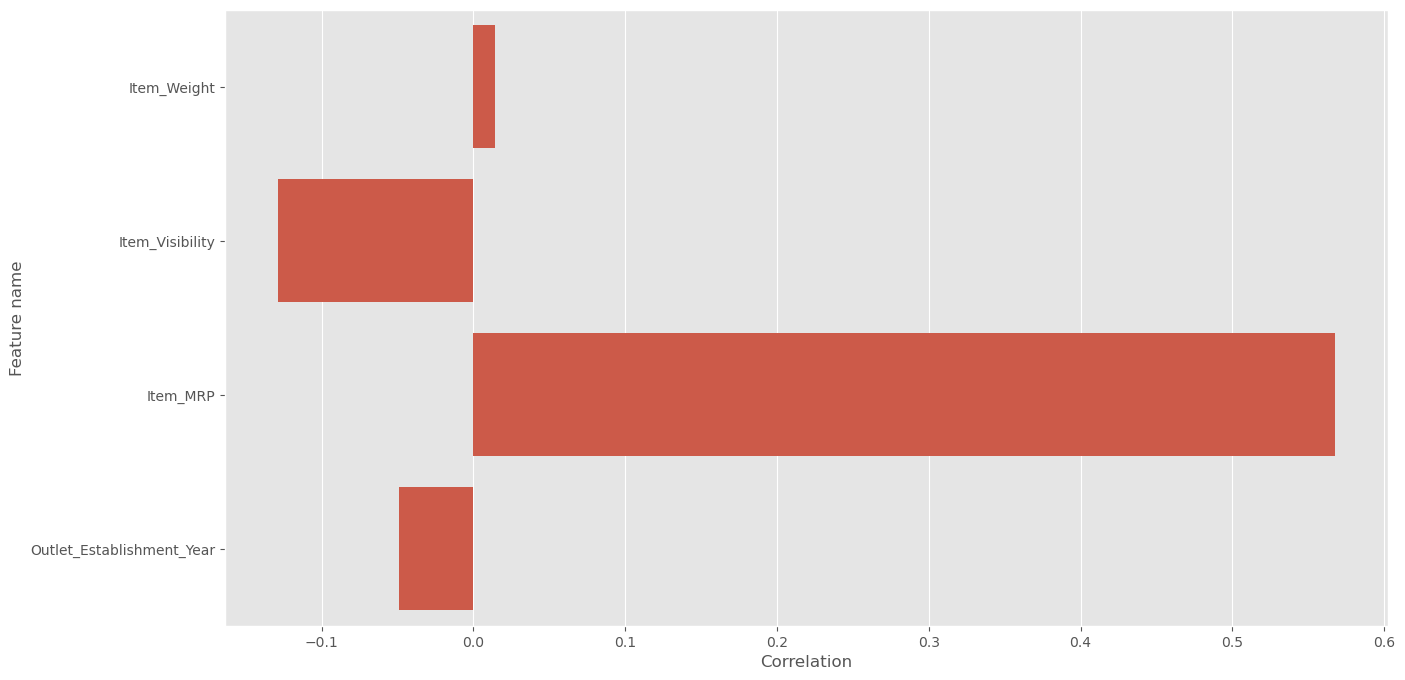

In [12]:
feat_corr_with_target = num_feat.corr().iloc[:-1, -1]

plt.figure(figsize=(15, 8))
sns.barplot(x=feat_corr_with_target.values, y=feat_corr_with_target.index)
plt.xlabel("Correlation")
plt.ylabel("Feature name")
plt.show()

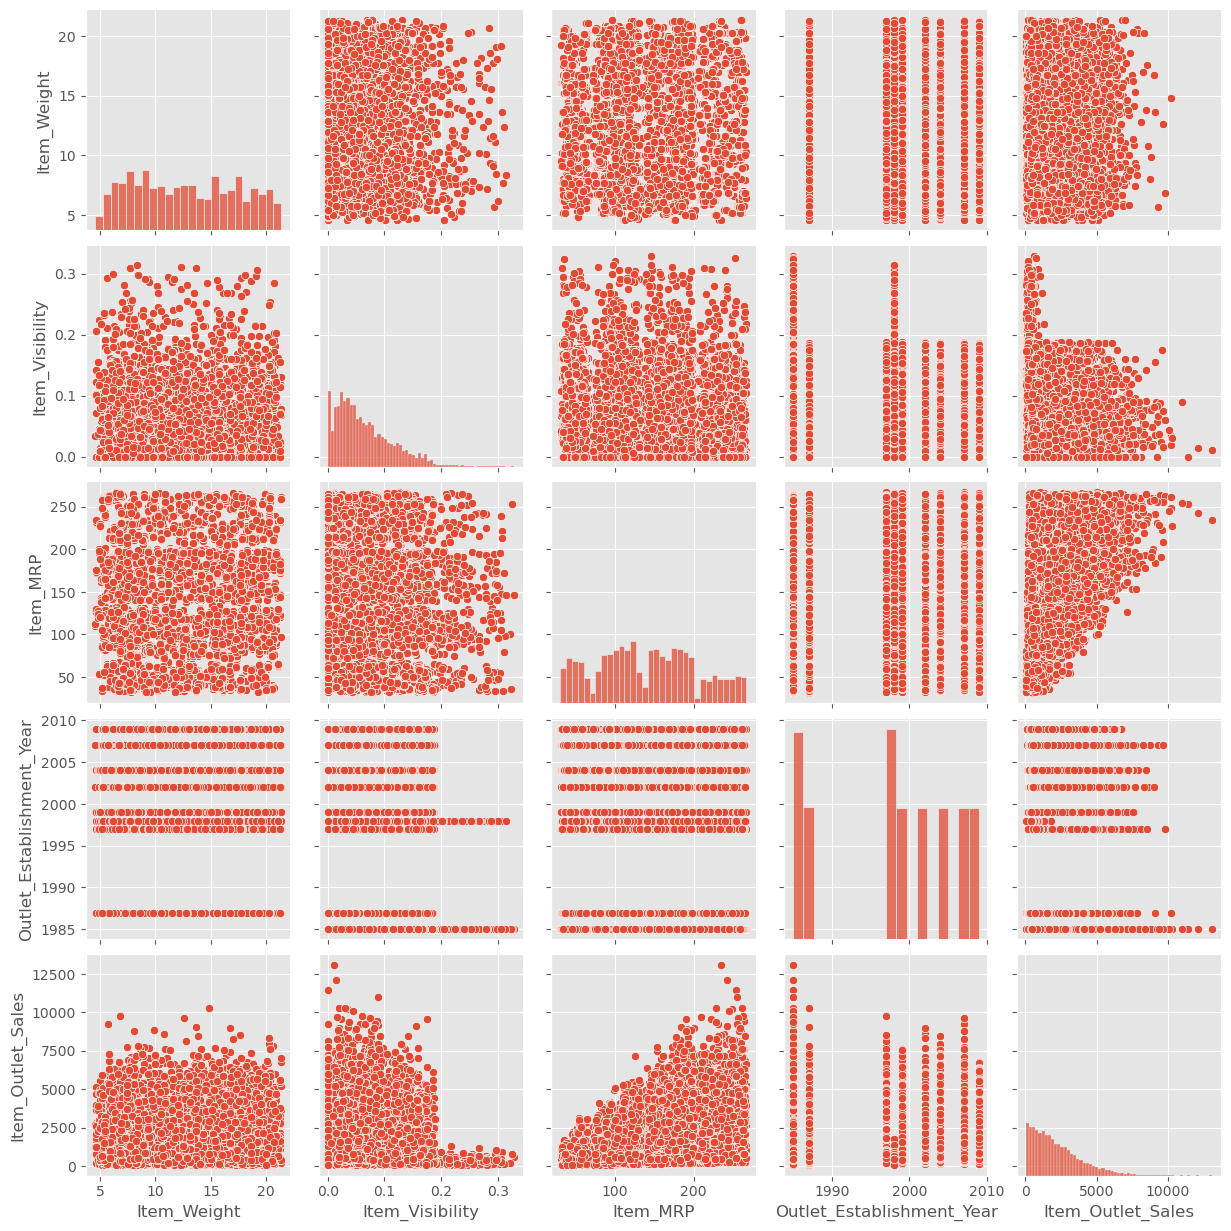

In [13]:
sns.pairplot(data=num_feat, dropna=True)
plt.show()

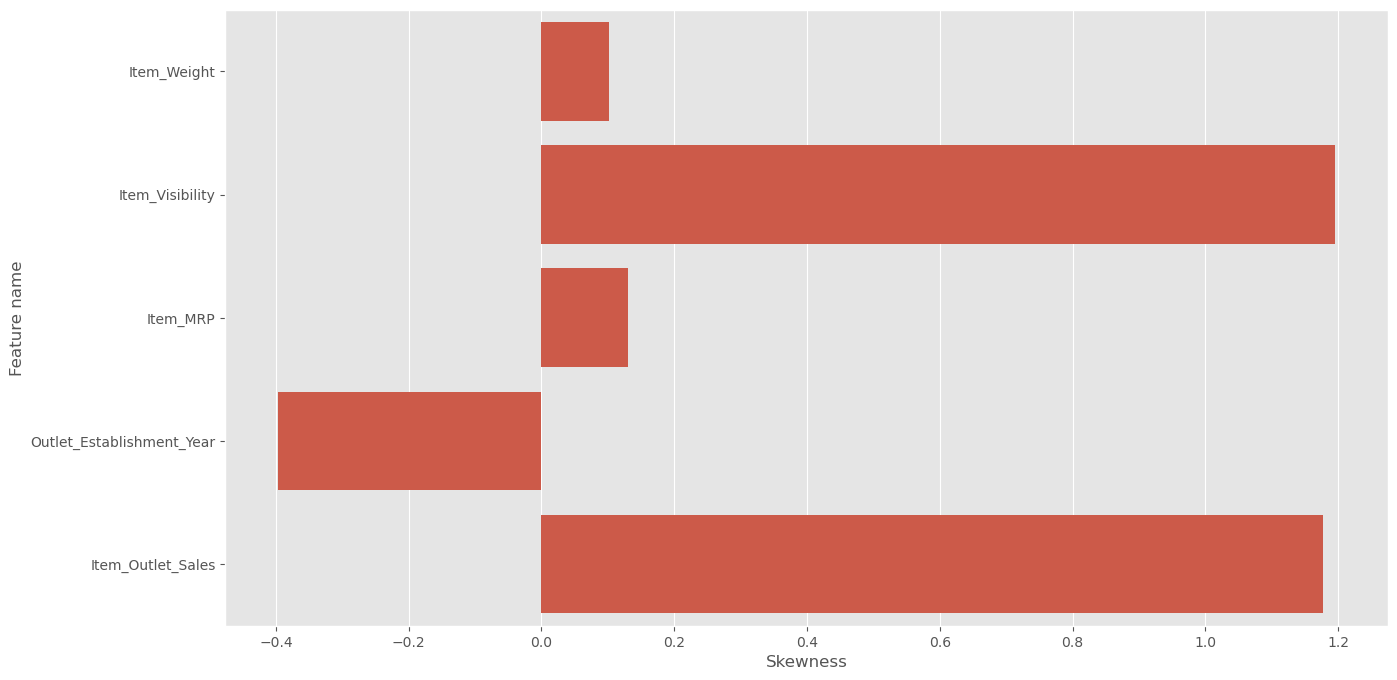

In [14]:
skewness = num_feat.skew()

plt.figure(figsize=(15, 8))
sns.barplot(x=skewness.values, y=skewness.index)
plt.xlabel("Skewness")
plt.ylabel("Feature name")
plt.show()

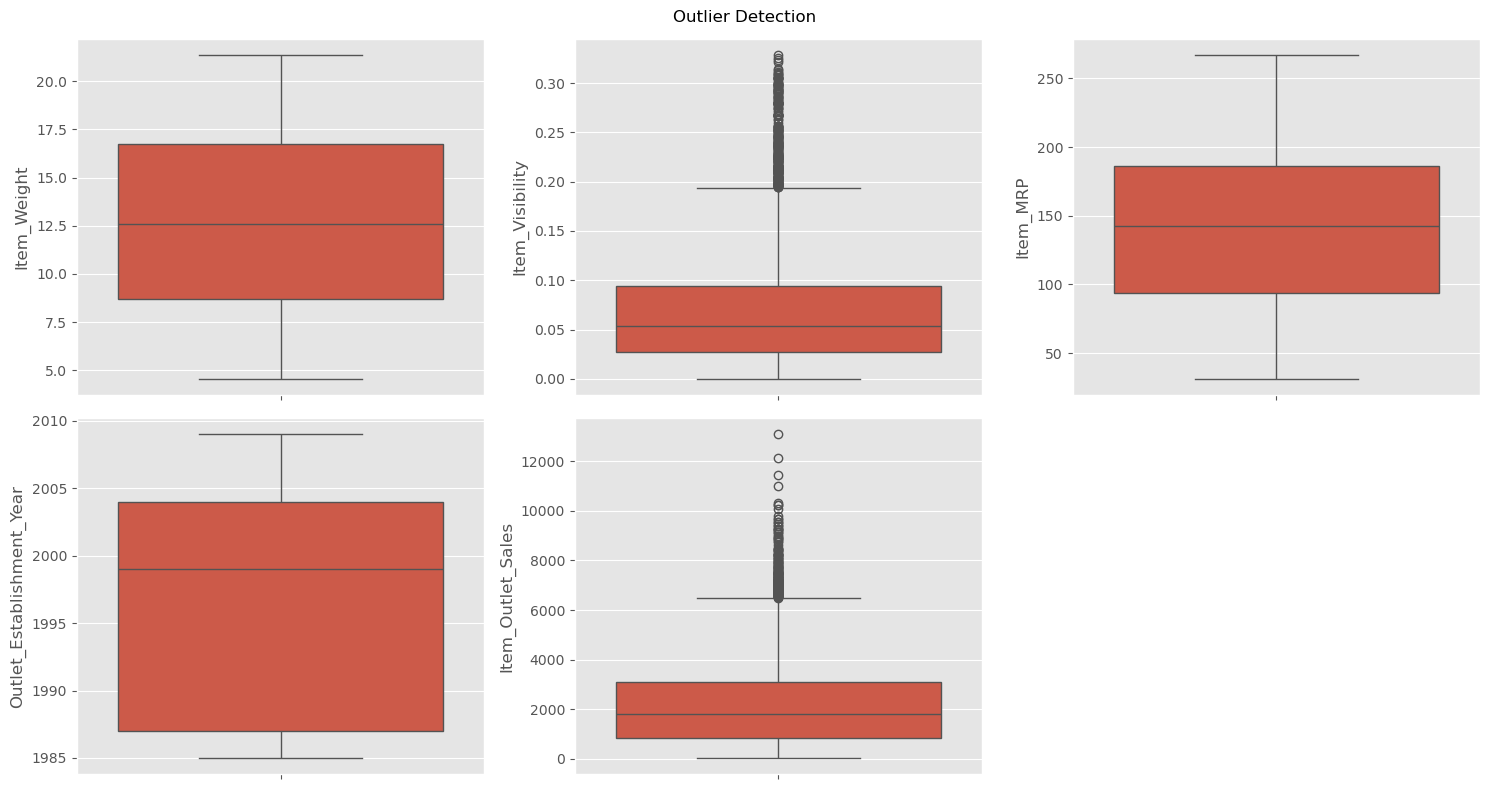

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for (idx, j) in enumerate(num_feat.columns, start=0):
    boxplot = sns.boxplot(num_feat[j], ax=axes[idx])

for i in axes[len(num_feat.columns):]:
    plt.delaxes(i)

plt.suptitle("Outlier Detection")
plt.tight_layout()
plt.show()

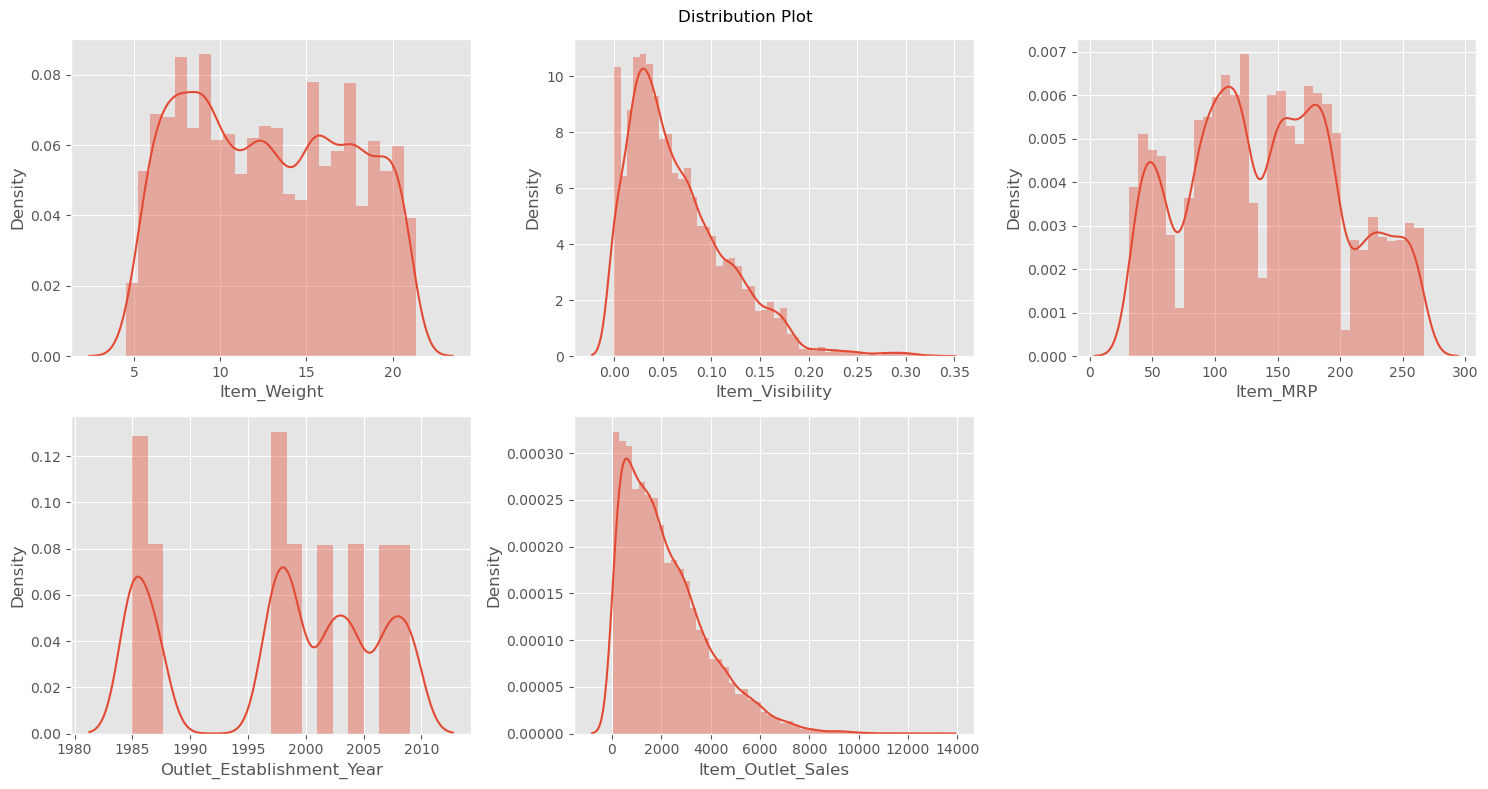

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for (idx, j) in enumerate(num_feat.columns, start=0):
    boxplot = sns.distplot(num_feat[j], ax=axes[idx])

for i in axes[len(num_feat.columns):]:
    plt.delaxes(i)

plt.suptitle("Distribution Plot")
plt.tight_layout()
plt.show()

In [17]:
# Fill in missing values in Item_Weight column with the mean of the column
num_feat["Item_Weight"] =  num_feat["Item_Weight"].fillna(num_feat["Item_Weight"].mean())

In [18]:
def OutlierFunc(data, col: list):
    df = data[col]
    q3 = df.quantile(0.75)
    q1 = df.quantile(0.25)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5*iqr, q3 + 1.5*iqr
    df[df < lower_bound] = np.mean(df)
    df[df > upper_bound] = np.mean(df)
                
    return df

In [19]:
# Replace outliers with their mean
num_feat["Item_Visibility"] = OutlierFunc(num_feat, ["Item_Visibility"])

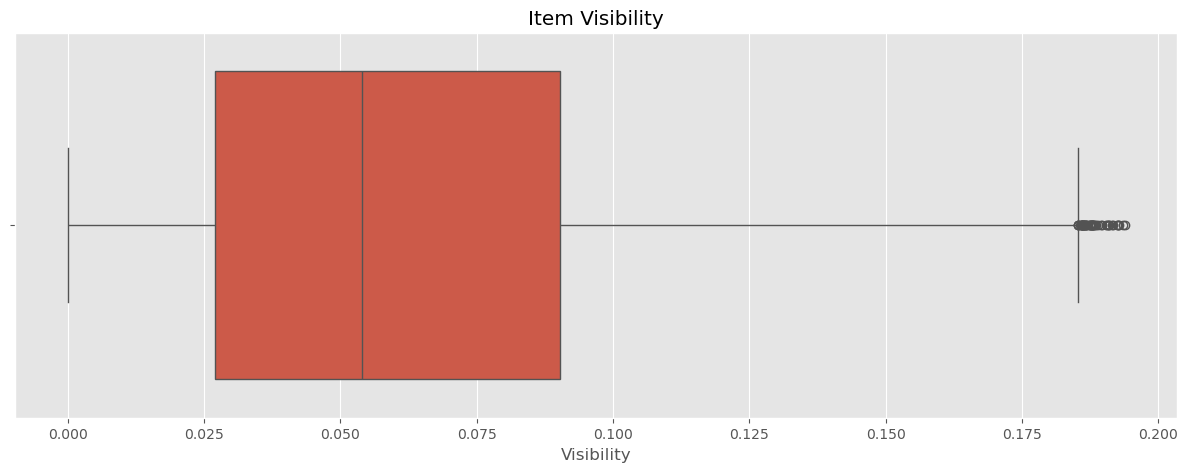

In [20]:
plt.figure(figsize=(15, 5))
sns.boxplot(x = num_feat["Item_Visibility"])
plt.xlabel("Visibility")
plt.title("Item Visibility")
plt.show()

In [21]:
for col in cat_feat.columns:
    print(cat_feat[col].value_counts())
    print("--------"*6)

Item_Identifier
FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
         ..
FDR51     7
FDM52     7
DRN11     7
FDH58     7
NCW54     7
Name: count, Length: 1559, dtype: int64
------------------------------------------------
Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: count, dtype: int64
------------------------------------------------
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64
------------------------------------------------
Outlet_Identifier
OUT027  

In [22]:
cat_feat["Item_Fat_Content"] = cat_feat["Item_Fat_Content"].replace({"reg":"Regular", "LF":"Low Fat", "low fat":"Low Fat"})

cat_feat["Outlet_Size"] = cat_feat["Outlet_Size"].fillna("Unkown")

In [23]:
prep_data = pd.concat([cat_feat, num_feat], axis=1)


prep_data.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,9.30,0.016047,249.8092,1999,3735.1380
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2,5.92,0.019278,48.2692,2009,443.4228
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1,17.50,0.016760,141.6180,1999,2097.2700
3,FDX07,Regular,Fruits and Vegetables,OUT010,Unkown,Tier 3,Grocery Store,19.20,0.000000,182.0950,1998,732.3800
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1,8.93,0.000000,53.8614,1987,994.7052


### OneHotEncoding

In [24]:
prep_data = pd.get_dummies(data=prep_data,
                           columns=["Outlet_Size","Outlet_Location_Type", "Outlet_Type", "Item_Fat_Content"],
                           dtype=float)

for col in ["Item_Identifier", "Item_Type", "Outlet_Identifier"]:
    prep_data[col] = LabelEncoder().fit_transform(prep_data[col])

### Standard Scaler

In [25]:
prep_data_ = pd.DataFrame(StandardScaler().fit_transform(prep_data.drop("Item_Outlet_Sales", axis=1)),
                         columns=prep_data.drop("Item_Outlet_Sales", axis=1).columns)

print(prep_data_.shape)
prep_data_.head()

(14204, 20)


,Item_Identifier,Item_Type,Outlet_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unkown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular
0,-1.388320,-0.766467,1.507764,-0.824939,-1.033948,1.752511,0.139681,-0.350367,1.432251,-0.623923,-0.627845,1.602761,-0.69664,-0.804739,-0.381545,0.726841,-0.349480,-0.351127,0.739212,-0.739212
1,-1.717498,1.606957,-0.607145,-1.623224,-0.962328,-1.493696,1.334228,-0.350367,1.432251,-0.623923,-0.627845,-0.623923,-0.69664,1.242639,-0.381545,-1.375817,2.861395,-0.351127,-1.352792,1.352792
2,-0.262885,0.657587,1.507764,1.111729,-1.018148,0.009874,0.139681,-0.350367,1.432251,-0.623923,-0.627845,1.602761,-0.69664,-0.804739,-0.381545,0.726841,-0.349480,-0.351127,0.739212,-0.739212
3,0.758014,-0.291782,-1.664600,1.513233,-1.389671,0.661838,0.020226,-0.350367,-0.698202,-0.623923,1.592750,-0.623923,-0.69664,1.242639,2.620926,-1.375817,-0.349480,-0.351127,-1.352792,1.352792
4,1.149470,0.420245,-1.312115,-0.912325,-1.389671,-1.403623,-1.293777,2.854149,-0.698202,-0.623923,-0.627845,-0.623923,-0.69664,1.242639,-0.381545,0.726841,-0.349480,-0.351127,0.739212,-0.739212


In [26]:
train_prep = pd.concat([prep_data_[:train.shape[0]], prep_data[:train.shape[0]]["Item_Outlet_Sales"]], axis=1)
test_prep = prep_data_[train.shape[0]:]

In [27]:
X, y = train_prep.drop("Item_Outlet_Sales", axis=1), train_prep["Item_Outlet_Sales"]

### Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [29]:
list_of_algo = [RandomForestRegressor, XGBRegressor, CatBoostRegressor, LGBMRegressor]

### Ensembling Technique

In [30]:
def Ensemble_Models(X_train, X_test, y_train, y_test, list_of_model, cv=5):
    kfold = KFold(n_splits=cv)

    prediction_per_model = pd.DataFrame()

    model_evaluation = []
    for algo in list_of_model:
        if algo.__name__ == "XGBRegressor":
            model = algo(verbosity=0)
        elif algo.__name__ == "CatBoostRegressor":
            model = algo(silent=True)
        elif algo.__name__ == "LGBMRegressor":
            model = algo(verbosity=-1)
        else:
            model = algo()
        
        pred_per_fold = pd.DataFrame()

        MAE = []
        MSE = []
        RMSE = []
        MSPE = []
        R2_SCORE = []
        
        for idx, (train_idx, test_idx) in enumerate(kfold.split(X_train, y_train)):
            x_train, x_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
            Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

            model.fit(x_train, Y_train)

            pred_per_fold[f"fold_{idx}"] = model.predict(X_test)

            MAE.append(metrics.mean_absolute_error(Y_test, model.predict(x_test)))
            MSE.append(metrics.mean_squared_error(Y_test, model.predict(x_test)))
            RMSE.append(np.sqrt(metrics.mean_squared_error(Y_test, model.predict(x_test))))
            MSPE.append(metrics.mean_absolute_percentage_error(Y_test, model.predict(x_test)))
            R2_SCORE.append(metrics.r2_score(Y_test, model.predict(x_test)))

        model_evaluation.append([algo.__name__, np.mean(MAE), np.mean(MSE), np.mean(RMSE), np.mean(MSPE), np.mean(R2_SCORE)])

        prediction_per_model[f"{algo.__name__}"] = pred_per_fold.mean(axis=1)

    print(tabulate(model_evaluation, headers=["Models", "MAE", "MSE", "RMSE", "MAPE", "R2_SCORE"], tablefmt="rounded_grid"))
        
    return prediction_per_model

In [31]:
TEST_PREDICTIONS = Ensemble_Models(X_train, X_test, y_train, y_test, list_of_algo, 5)

╭───────────────────────┬─────────┬─────────────┬─────────┬──────────┬────────────╮
│ Models                │     MAE │         MSE │    RMSE │     MAPE │   R2_SCORE │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ RandomForestRegressor │ 799.635 │ 1.30254e+06 │ 1141.02 │ 0.576911 │   0.554157 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ XGBRegressor          │ 852.149 │ 1.4528e+06  │ 1204.84 │ 0.653418 │   0.502809 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ CatBoostRegressor     │ 789.475 │ 1.27e+06    │ 1126.59 │ 0.588461 │   0.565355 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ LGBMRegressor         │ 782.395 │ 1.25953e+06 │ 1121.96 │ 0.576391 │   0.568906 │
╰───────────────────────┴─────────┴─────────────┴─────────┴──────────┴────────────╯


In [32]:
print(f"MAE: {metrics.mean_absolute_error(y_test, TEST_PREDICTIONS.mean(axis=1))}")
print(f"MSE: {metrics.mean_squared_error(y_test, TEST_PREDICTIONS.mean(axis=1))}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, TEST_PREDICTIONS.mean(axis=1)))}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, TEST_PREDICTIONS.mean(axis=1))}")
print(f"R2_SCORE: {metrics.r2_score(y_test, TEST_PREDICTIONS.mean(axis=1))}")

MAE: 735.8037486584129
MSE: 1120699.0510738436
RMSE: 1058.630743495504
MAPE: 0.5500571713978379
R2_SCORE: 0.599156831159796


### Stacking Models 

In [33]:
stacked_models = StackingRegressor(estimators=[("XGBRegressor", XGBRegressor()), 
                                               ("CatBoostRegressor", CatBoostRegressor()),
                                               ("LGBMRegressor", LGBMRegressor())], 
                                               final_estimator=RandomForestRegressor(), 
                                               cv = 5, 
                                               n_jobs= -1)

In [34]:
def Stacking_models(estimator, X_train, X_test, y_train, y_test, cv):
    kfold = KFold(n_splits=cv)
    
    model_evaluation = []

    Test_prediction = pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(kfold.split(X_train, y_train)):
        XTRAIN, XTEST = X_train.iloc[train_idx], X_train.iloc[test_idx]
        YTRAIN, YTEST = y_train.iloc[train_idx], y_train.iloc[test_idx]

        estimator.fit(XTRAIN, YTRAIN)

        Test_prediction[f"Fold {idx}"] = estimator.predict(X_test)
        
        model_evaluation.append([
            metrics.mean_absolute_error(YTEST, estimator.predict(XTEST)),
            metrics.mean_squared_error(YTEST, estimator.predict(XTEST)),
            np.sqrt(metrics.mean_squared_error(YTEST, estimator.predict(XTEST))),
            metrics.mean_absolute_percentage_error(YTEST, estimator.predict(XTEST)),
            metrics.r2_score(YTEST, estimator.predict(XTEST))
        ])

    print(
        tabulate(
                   tabular_data=model_evaluation,
                   headers=["MAE", "MSE", "RMSE", "MAPE", "R2_SCORE"],
                   tablefmt="rounded_grid",
                   showindex="True"
                )
         )

    return Test_prediction

In [35]:
STACKED_MODEL_PREDICTION = Stacking_models(stacked_models, X_train, X_test, y_train, y_test, 5)

╭─────────┬─────────────┬─────────┬──────────┬────────────╮
│     MAE │         MSE │    RMSE │     MAPE │   R2_SCORE │
├─────────┼─────────────┼─────────┼──────────┼────────────┤
│ 816.389 │ 1.39178e+06 │ 1179.74 │ 0.63614  │   0.502509 │
├─────────┼─────────────┼─────────┼──────────┼────────────┤
│ 794.242 │ 1.29281e+06 │ 1137.02 │ 0.590075 │   0.541581 │
├─────────┼─────────────┼─────────┼──────────┼────────────┤
│ 814.144 │ 1.34092e+06 │ 1157.98 │ 0.6393   │   0.550572 │
├─────────┼─────────────┼─────────┼──────────┼────────────┤
│ 834.069 │ 1.46792e+06 │ 1211.58 │ 0.578033 │   0.51325  │
├─────────┼─────────────┼─────────┼──────────┼────────────┤
│ 853.476 │ 1.47466e+06 │ 1214.36 │ 0.587082 │   0.50683  │
╰─────────┴─────────────┴─────────┴──────────┴────────────╯


In [36]:
print(f"MAE: {metrics.mean_absolute_error(y_test, STACKED_MODEL_PREDICTION.mean(axis=1))}")
print(f"MSE: {metrics.mean_squared_error(y_test, STACKED_MODEL_PREDICTION.mean(axis=1))}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, STACKED_MODEL_PREDICTION.mean(axis=1)))}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, STACKED_MODEL_PREDICTION.mean(axis=1))}")
print(f"R2_SCORE: {metrics.r2_score(y_test, STACKED_MODEL_PREDICTION.mean(axis=1))}")

MAE: 748.7245423343493
MSE: 1133890.668411767
RMSE: 1064.8430252444568
MAPE: 0.5681608766599149
R2_SCORE: 0.5944385531432366


### Feaure Engineering

In [37]:
feat_eng = pd.concat([train, test])
print(feat_eng.shape)
feat_eng.head()

(14204, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


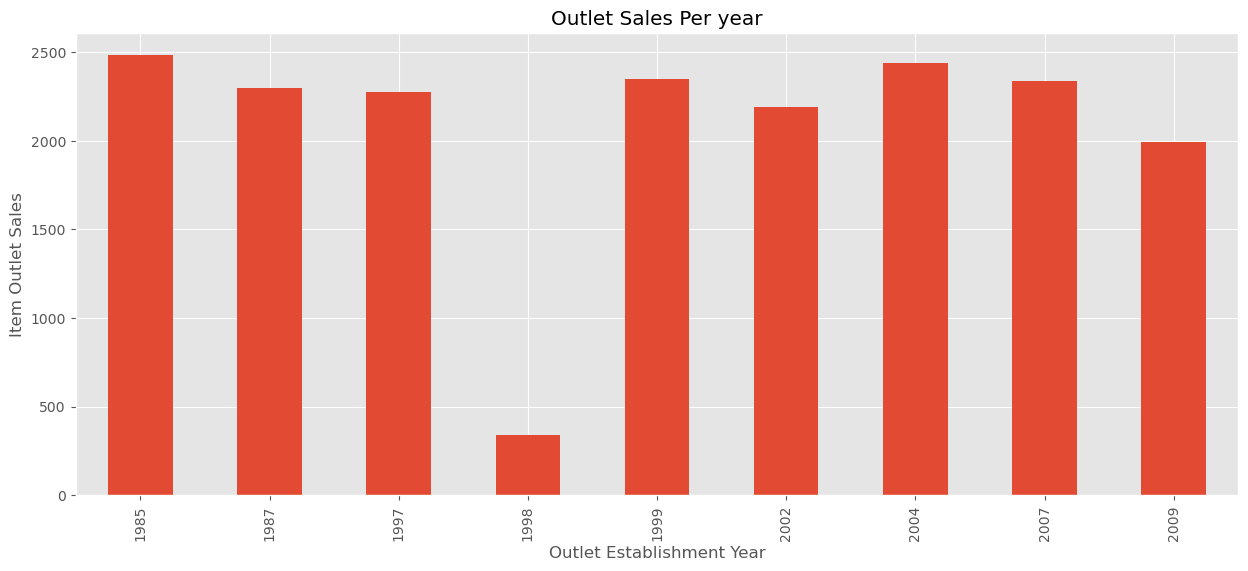

In [38]:
feat_eng.groupby("Outlet_Establishment_Year")["Item_Outlet_Sales"].mean().plot(kind="bar", 
                                                                               title="Outlet Sales Per year",
                                                                               xlabel="Outlet Establishment Year",
                                                                               ylabel="Item Outlet Sales",
                                                                               figsize=(15, 6))
plt.show()

In [39]:
feat_eng["Item_Fat_Content"] = feat_eng["Item_Fat_Content"].replace({"reg":"Regular", "LF":"Low Fat", "low fat":"Low Fat"})
feat_eng["item_age"] = 2009 - feat_eng["Outlet_Establishment_Year"]
feat_eng.drop("Outlet_Establishment_Year", axis=1, inplace=True)
feat_eng["Item_Type"] = feat_eng["Item_Type"].replace({
                                                        'Fruits and Vegetables': 'Food Items',
                                                        'Snack Foods': 'Food Items',
                                                        'Household': 'Household and Personal Care',
                                                        'Frozen Foods': 'Food Items',
                                                        'Dairy': 'Food Items',
                                                        'Baking Goods': 'Food Items',
                                                        'Canned': 'Food Items',
                                                        'Health and Hygiene': 'Household and Personal Care',
                                                        'Meat': 'Food Items',
                                                        'Soft Drinks': 'Beverages',
                                                        'Breads': 'Food Items',
                                                        'Hard Drinks': 'Beverages',
                                                        'Others': 'Household and Personal Care',
                                                        'Starchy Foods': 'Food Items',
                                                        'Breakfast': 'Food Items',
                                                        'Seafood': 'Food Items'
                                                    })
feat_eng["Item_Visibility"] = feat_eng["Item_Visibility"].replace({0:feat_eng["Item_Visibility"].mean()})

### Frequency Encoding 

In [40]:
feat_eng["Item_Fat_Content"] = feat_eng["Item_Fat_Content"].map(feat_eng["Item_Fat_Content"].value_counts() / feat_eng.shape[0])
feat_eng["Item_Type"] = feat_eng["Item_Type"].map(feat_eng["Item_Type"].value_counts() / feat_eng.shape[0])
feat_eng["Outlet_Identifier"] = feat_eng["Outlet_Identifier"].map(feat_eng["Outlet_Identifier"].value_counts() / feat_eng.shape[0])
feat_eng["Outlet_Size"] = feat_eng["Outlet_Size"].fillna("unknown")
feat_eng["Outlet_Size"] = feat_eng["Outlet_Size"].map(feat_eng["Outlet_Size"].value_counts() / feat_eng.shape[0])
feat_eng["Outlet_Location_Type"] = feat_eng["Outlet_Location_Type"].map(feat_eng["Outlet_Location_Type"].value_counts() / feat_eng.shape[0])
feat_eng["Outlet_Type"] = feat_eng["Outlet_Type"].map(feat_eng["Outlet_Type"].value_counts() / feat_eng.shape[0])
feat_eng["Item_Identifier"] = feat_eng["Item_Identifier"].map(feat_eng["Item_Identifier"].value_counts() / feat_eng.shape[0])

In [41]:
feat_eng["Item_Weight"] = feat_eng["Item_Weight"].fillna(feat_eng["Item_Weight"].mean())

### Feature Scaling

In [42]:
scaled_data = feat_eng.drop(["Item_Outlet_Sales", "Item_Weight"], axis="columns").apply(zscore) 

In [43]:
scaled_train_data = scaled_data[:train.shape[0]]
target = feat_eng[:train.shape[0]]["Item_Outlet_Sales"]

scaled_test_data = scaled_data[train.shape[0]:]

### Train Test Split

In [44]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(scaled_train_data, target, test_size=0.1, random_state=42, shuffle=True)

In [45]:
TEST_PREDICTIONS = Ensemble_Models(X_train_, X_test_, y_train_, y_test_, list_of_algo, 5)

╭───────────────────────┬─────────┬─────────────┬─────────┬──────────┬────────────╮
│ Models                │     MAE │         MSE │    RMSE │     MAPE │   R2_SCORE │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ RandomForestRegressor │ 806.911 │ 1.3248e+06  │ 1150.85 │ 0.576646 │   0.546474 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ XGBRegressor          │ 835.876 │ 1.42043e+06 │ 1191.68 │ 0.619751 │   0.513672 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ CatBoostRegressor     │ 785.766 │ 1.25933e+06 │ 1121.93 │ 0.573467 │   0.569023 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ LGBMRegressor         │ 776.339 │ 1.24371e+06 │ 1114.98 │ 0.564027 │   0.574316 │
╰───────────────────────┴─────────┴─────────────┴─────────┴──────────┴────────────╯


### Final Prediction

In [46]:
final_predictions = Ensemble_Models(X_train, test_prep, y_train, None, list_of_algo, 5)

╭───────────────────────┬─────────┬─────────────┬─────────┬──────────┬────────────╮
│ Models                │     MAE │         MSE │    RMSE │     MAPE │   R2_SCORE │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ RandomForestRegressor │ 801.172 │ 1.30865e+06 │ 1143.75 │ 0.576816 │   0.552055 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ XGBRegressor          │ 852.149 │ 1.4528e+06  │ 1204.84 │ 0.653418 │   0.502809 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ CatBoostRegressor     │ 789.475 │ 1.27e+06    │ 1126.59 │ 0.588461 │   0.565355 │
├───────────────────────┼─────────┼─────────────┼─────────┼──────────┼────────────┤
│ LGBMRegressor         │ 782.395 │ 1.25953e+06 │ 1121.96 │ 0.576391 │   0.568906 │
╰───────────────────────┴─────────┴─────────────┴─────────┴──────────┴────────────╯


In [47]:
final_predictions

,RandomForestRegressor,XGBRegressor,CatBoostRegressor,LGBMRegressor
0,1569.033601,1343.647095,1481.380857,1572.444052
1,1224.633904,1282.558594,1308.147424,1354.731012
2,546.761618,631.818848,810.420865,576.327148
3,2233.214376,2151.286621,2390.796079,2376.073657
4,5812.418021,6068.629395,5886.383070,6430.141230
...,...,...,...,...
5676,2279.645936,2377.885986,2120.081462,2095.843441
5677,2931.486773,2979.539062,2617.495776,2535.123384
5678,1888.761414,1899.691650,1858.536482,1902.180567
5679,4401.679701,4363.020996,4352.719533,4357.982956
